In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
# Global variables
ROOT = "/users/kcochran/projects/domain_adaptation_nosexchr/"

# shorthand for each TF name
tfs = ["CTCF", "CEBPA", "Hnf4a", "RXRA"]
# plot-acceptable TF names
tfs_latex_names = ["CTCF", "CEBPA", "HNF4A", "RXRA"]

# shorthand names for all model types to include in plots
all_trainspecies = ["mm10", "DA", "hg38", "NS"]
# plot-acceptable names for model types
model_names_dict = {"mm10" : "Mouse",
                    "hg38" : "Human",
                    "DA" : "Mouse+DA",
                    "NS" : "Human-NS"}

# Constants to be used for plot appearance details
DOT_SIZE = 5
ALPHA = 0.03
AXIS_SIZE = 11
AX_OFFSET = 0.02
TF_TWINAX_OFFSET = 0.35
FIG_SIZE_UNIT = 5
FIG_SIZE_2_by_4 = (FIG_SIZE_UNIT, FIG_SIZE_UNIT * 2)
FIG_SIZE_1_by_2 = (FIG_SIZE_UNIT / 2, FIG_SIZE_UNIT)
BOUND_SUBSAMPLE_RATE = 4

# If you don't care about plotting all examples
# and want to speed things up, you can set SKIP to not None;
# every SKIP-th ***UNBOUND*** example will be used in model evaluation.
# Note that since bound sites are so sparse, SKIP only applies
# to UNBOUND sites.
SKIP = 200

In [3]:
import random
random.seed(1234) 

In [4]:
def get_preds_file(tf, train_species, test_species):
    preds_root = ROOT + "/model_out/"
    return preds_root + tf + "_" + train_species + "-trained_" + test_species + "-test.preds.npy"


def load_average_test_set_preds(test_species = "hg38"):
    # takes a while to run.
    preds_dict = defaultdict(lambda : dict())

    # loop over mouse-trained, human-trained models, and DA mouse-trained models
    for train_species in all_trainspecies:
        for tf in tfs:
            print("=== " + tf + ", " + train_species + "-trained ===")

            # load predictions for all 5 independent model runs
            preds_file = get_preds_file(tf, train_species, test_species)
            try:
                preds_dict[train_species][tf] = np.mean(np.load(preds_file), axis = 1)
            except:
                print("Could not load preds file:", preds_file)
            
    return preds_dict

avg_preds_human_test = load_average_test_set_preds()

=== CTCF, mm10-trained ===
=== CEBPA, mm10-trained ===
=== Hnf4a, mm10-trained ===
=== RXRA, mm10-trained ===
=== CTCF, DA-trained ===
=== CEBPA, DA-trained ===
=== Hnf4a, DA-trained ===
=== RXRA, DA-trained ===
=== CTCF, hg38-trained ===
=== CEBPA, hg38-trained ===
=== Hnf4a, hg38-trained ===
=== RXRA, hg38-trained ===
=== CTCF, NS-trained ===
=== CEBPA, NS-trained ===
=== Hnf4a, NS-trained ===
=== RXRA, NS-trained ===


In [5]:
def get_test_bed_file(tf, species):
    # This function returns the path to a BED-format file
    # containing the chromosome names, starts, and ends for
    # all examples to test the model with.
    # Note this is specific to a TF (binding labels
    # are loaded in from this file)!
    return(ROOT + "data/" + species + "/" + tf + "/chr2.bed")


def get_test_labels(tf, species = "hg38"):
    # This function reads in the test-data bed file 
    # for a given species and TF and returns the binding labels
    # for each example in that file.
    labels_file = get_test_bed_file(tf, species)
    with open(labels_file) as f:
        return np.array([int(line.split()[-1]) for line in f])
        

def get_test_labels_all_tfs(species = "hg38"):
    labels = dict()
    for tf in tfs:
        labels_for_tf = get_test_labels(tf)
        # assuming the mm10 entry exists, species doesn't matter here
        # shape of preds array should be the same in all cases
        len_to_truncate_by = avg_preds_human_test["mm10"][tf].shape[0]
        labels[tf] = labels_for_tf[:len_to_truncate_by]
        
    return labels

labels = get_test_labels_all_tfs()

In [6]:
def get_alu_intersect_file_chr2():
    # See make_repeat_files.sh for creating this file.
    # Basically:
    # awk '$1 == "chr2"' [repeatmaker alu file] > rmsk_alus_chr2.bed
    # bedtools intersect -a [get_test_bed_file(species)] -b rmsk_alus_chr2.bed -u -sorted > chr2_alus_intersect.bed
    
    # This file should contain all windows in the test data
    # that intersect with Alus (this is different from all
    # annotated Alus -- model is expecting windows of the
    # correct size).
    
    # This file is not specific to a TF.
    return(ROOT + "data/hg38/chr2_alus_intersect.bed")


def get_window_starts_fast(filename):
    # assuming the file is in bed format and col 2 is what we want
    df = pd.read_csv(filename, sep='\t', header=None)
    starts = np.array(df[1])
    return starts


def matches_across_sorted_lists(list_a, list_b):
    # this function is NOT symmetric!!!
    # the output will have len equal to len of list_a
    
    # here we assume that list_b is a subset of list_a
    # (doesn't contain elements not found in list_a)
    matches = []
    b_index = 0
    for a_item in list_a:
        while True:
            if b_index >= len(list_b):
                matches.append(False)
                break
            if list_b[b_index] > a_item:
                matches.append(False)
                break
            else:
                assert list_b[b_index] == a_item
                matches.append(True)
                b_index += 1
                break
    return np.array(matches)

   
def get_alu_labels():
    alu_starts = get_window_starts_fast(get_alu_intersect_file_chr2())
    # which tf here doesn't matter; not using labels
    all_starts = get_window_starts_fast(get_test_bed_file(tfs[0], "hg38"))
    alu_labels = matches_across_sorted_lists(all_starts, alu_starts)
    alu_indices = set(np.nonzero(alu_labels)[0])
    return alu_labels, alu_indices


alu_labels, alu_indices = get_alu_labels()

In [7]:
def make_preds_and_labels_dfs(avg_preds_human_test, labels, alu_labels):
    preds_dfs = dict()
    for tf in tfs:
        dict_to_make_into_df = {"labels" : labels[tf]}
        goal_len = labels[tf].shape[0]  # assuming labels are already truncated
        
        for train_species in all_trainspecies:
            print()
            preds_from_train_species = avg_preds_human_test[train_species][tf]
            assert preds_from_train_species.shape[0] == goal_len
            dict_to_make_into_df[train_species] = preds_from_train_species
            
        dict_to_make_into_df["alu_labels"] = alu_labels[:goal_len]
        preds_dfs[tf] = pd.DataFrame(dict_to_make_into_df)
        
    return preds_dfs
        
preds_and_labels_dfs = make_preds_and_labels_dfs(avg_preds_human_test, labels, alu_labels)

# Plotting

In [8]:
def bound_scatterplot(model1_preds, model2_preds, tf_name,
                      plot_index, model_names):
    # This function draws a single scatterplot of bound sites (subplot of figure).
    # model1_preds: x-axis values for all points to plot
    # model2_preds: y-axis values for all points to plot
    # plot_index: either 0 or 1. 0 = top plot in column, 1 = bottom plot.
    # model_names: plot-acceptable names for the models that generated the x-axis
    #     and y-axis predictions, respectively. Expecting a list of length 2.
    
    # First, a random sample of sites are chosen, so that
    # the plot is not too overcrowded
    model_preds_subsample = random.sample(list(zip(model1_preds, model2_preds)),
                            k = int(len(model1_preds) / BOUND_SUBSAMPLE_RATE))
    model1_preds_subsample = [pair[0] for pair in model_preds_subsample]
    model2_preds_subsample = [pair[1] for pair in model_preds_subsample]
    
    # Then each bound site is plotted as an individual dot on a scatter plot
    plt.scatter(model1_preds_subsample, model2_preds_subsample,
                alpha = ALPHA, s = DOT_SIZE, c = "#007DEA")
    
    # adjust axes to show all points, add ticks
    plt.xlim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.ylim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    
    # add axis labels
    if len(model_names[1]) > 5:
        plt.ylabel(model_names[1] + "\nModel Prediction", fontsize = AXIS_SIZE)
    else:
        plt.ylabel(model_names[1] + " Model Prediction", fontsize = AXIS_SIZE)
        
    # add x-axis label only if this subplot is the bottom row of the figure
    if plot_index == len(tfs) - 1:
        if len(model_names[0]) > 5:  # adjust fontsize for longer model names
            plt.xlabel(model_names[0] + " Model Prediction", fontsize = AXIS_SIZE - 1)
        else:
            plt.xlabel(model_names[0] + " Model Prediction", fontsize = AXIS_SIZE)
        
    # add second "axis" to write TF name to the left of the plot
    # only do this for bound scatterplots because they are in left column of figure
    ax2 = plt.gca().twinx()
    if len(model_names[1]) > 5:
        ax2.spines["left"].set_position(("axes", 0 - 1.2 * TF_TWINAX_OFFSET))
    else:
        ax2.spines["left"].set_position(("axes", 0 - TF_TWINAX_OFFSET))
    ax2.yaxis.set_label_position('left')
    ax2.yaxis.set_ticks_position('none')
    ax2.set_yticklabels([])
    ax2.set_ylabel(tf_name, fontsize = AXIS_SIZE + 2)
    
    # add text above subplot only if we are drawing in the top row of the figure
    if plot_index == 0:
        ax3 = plt.gca().twiny()
        ax3.spines["top"].set_position(("axes", 1))
        ax3.set_xticklabels([])
        ax3.set_xticks([])
        ax3.set_xlabel("Bound Sites", fontsize = AXIS_SIZE + 2)
    
    
    
def unbound_scatterplot(model1_preds, model2_preds,
                        plot_index, model_names):
    # This function draws a single scatterplot of unbound sites.
    # model1_preds: x-axis values for all points to plot
    # model2_preds: y-axis values for all points to plot
    # plot_index: either 0 or 1. 0 = top plot in column, 1 = bottom plot.
    # model_names: plot-acceptable names for the models that generated the x-axis
    #     and y-axis predictions, respectively. Expecting a list of length 2.
    
    # no subsampling here, as in bound_scatterplot(),
    # because we already subsampled unbound sites using SKIP
    plt.scatter(model1_preds, model2_preds, alpha = ALPHA, s = DOT_SIZE, c = "#D60242")
    
    # adjust axes
    plt.xlim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.ylim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.xticks([0, 0.5, 1])
    
    # label x-axis only if we are drawing subplot in bottom row of figure
    if plot_index == len(tfs) - 1:
        if len(model_names[0]) > 5:  # adjust fontsize for longer model names
            plt.xlabel(model_names[0] + " Model Prediction", fontsize = AXIS_SIZE - 1)
        else:
            plt.xlabel(model_names[0] + " Model Prediction", fontsize = AXIS_SIZE)
        
    # add text above subplot only if we are drawing in the top row of the figure
    if plot_index == 0:
        ax2 = plt.gca().twiny()
        ax2.spines["top"].set_position(("axes", 1))
        ax2.set_xticklabels([])
        ax2.set_xticks([])
        ax2.set_xlabel("Unbound Sites", fontsize = AXIS_SIZE + 2)

        
        
def generate_bound_unbound_scatters(preds_and_labels_dfs, train_species,
                                    save_files = False):
    # This function generates the full Figure 4,7, or 10 (bound and unbound sites).
    # preds_dict: a 3-layer dictionary, where keys for layer 1 are ["bound", "unbound"],
    #     keys for layer 2 are TF names, and keys for layer 3 are model type / species
    #     names (["mm10", "DA", "hg38"]).
    # train_species: a list of length 2 containing the model type / species names for
    #     the model predictions to plot on the x and y axes, respectively. Will be used
    #     to index into layer 3 of preds_dict.
    
    assert len(train_species) == 2, train_speies
    
    # translate short-hand model type names for plot-acceptable names
    model_names = [model_names_dict[string] for string in train_species]

    # setup subplots: two columns (1 for bound sites, 1 for unbound, 4 rows (1 per TF)
    mpl.rcParams.update(mpl.rcParamsDefault)
    fig, ax = plt.subplots(nrows = len(tfs), ncols = 2, figsize = FIG_SIZE_2_by_4,
                           sharex = True, sharey = True,
                           gridspec_kw = {'hspace': 0.08, 'wspace': 0.13})

    # iterate over rows of subplots
    for plot_index,tf in enumerate(tfs):
        # left subplot in this row will be for bound sites
        plt.sca(ax[plot_index][0])
        
        bound_sites_for_tf = preds_and_labels_dfs[tf]
        bound_sites_for_tf = bound_sites_for_tf[bound_sites_for_tf["labels"] == 1]
        
        bound_scatterplot(bound_sites_for_tf[train_species[0]],
                          bound_sites_for_tf[train_species[1]],
                          tfs_latex_names[plot_index], plot_index, model_names)

        # right subplot in this row will be for unbound sites
        plt.sca(ax[plot_index][1])
        
        unbound_sites_for_tf = preds_and_labels_dfs[tf]
        unbound_sites_for_tf = unbound_sites_for_tf[unbound_sites_for_tf["labels"] == 0]
        
        if SKIP is not None:
            unbound_sites_for_tf = unbound_sites_for_tf[::SKIP]
        
        unbound_scatterplot(unbound_sites_for_tf[train_species[0]],
                            unbound_sites_for_tf[train_species[1]],
                            plot_index, model_names)
    
    if save_files:
        plt.savefig(ROOT + "plots/scatter_" + train_species[0] + "_" + train_species[1] + ".pdf",
                    bbox_inches='tight', pad_inches = 0)
        plt.savefig(ROOT + "plots/scatter_" + train_species[0] + "_" + train_species[1] + ".png",
                    bbox_inches='tight', pad_inches = 0)
        
    plt.show()
        

In [9]:
def alu_unbound_scatterplot(model1_preds, model2_preds, tf_name, plot_index, model_names):
    # This function draws one scatterplot of unbound Alu windows.
    # model1_preds: x-axis values for all points to plot
    # model2_preds: y-axis values for all points to plot
    # plot_index: either 0 or 1. 0 = top plot in column, 1 = bottom plot.
    # model_names: plot-acceptable names for the models that generated the x-axis
    #     and y-axis predictions, respectively. Expecting a list of length 2.
    
    plt.scatter(model1_preds, model2_preds, alpha = ALPHA, s = DOT_SIZE, c = "#D60242")
    plt.xlim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.ylim(0 - AX_OFFSET, 1 + AX_OFFSET)
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    
    if len(model_names[1]) > 5:
        plt.ylabel(model_names[1] + "\nModel Prediction", fontsize = AXIS_SIZE)
    else:
        plt.ylabel(model_names[1] + " Model Prediction", fontsize = AXIS_SIZE)
    
    # if plot_index is 1, we are at the bottom row in this column of subplots
    # so we should add the x-axis label
    if plot_index == len(tfs) // 2 - 1:
        if len(model_names[0]) > 5:
            plt.xlabel(model_names[0] + " Model Prediction", fontsize = AXIS_SIZE - 1)
        else:
            plt.xlabel(model_names[0] + " Model Prediction", fontsize = AXIS_SIZE)
    
    # this second axis is actually the TF name on the left of the normal y-axis label
    ax2 = plt.gca().twinx()
    if len(model_names[1]) > 5:
        ax2.spines["left"].set_position(("axes", 0 - 1.2 * TF_TWINAX_OFFSET))
    else:
        ax2.spines["left"].set_position(("axes", 0 - TF_TWINAX_OFFSET))
    ax2.yaxis.set_label_position('left')
    ax2.yaxis.set_ticks_position('none')
    ax2.set_yticklabels([])
    ax2.set_ylabel(tf_name, fontsize = AXIS_SIZE + 2)
    
    # if we are at the top subplot in the column, add the column "title" above
    if plot_index == 0:
        ax2 = plt.gca().twiny()
        ax2.spines["top"].set_position(("axes", 1))
        ax2.set_xticklabels([])
        ax2.set_xticks([])
        ax2.set_xlabel("Unbound " + r"$\it{Alus}$", fontsize = AXIS_SIZE + 2)
        
        
# run twice, to get 2 x 2 for 4 TFs
# once with tf_split_half = 1 and once with tf_split_half = 2
def generate_unbound_alu_scatters(preds_dict, train_species, tf_split_half = 1,
                                  save_files = False):
    # This function generates half of the plot shown in Figures 5 and 11.
    # if tf_split_half = 1, the left half of the plot is drawn; if 2, the right half.
    # preds_dict: a 3-layer dictionary, where keys for layer 1 are ["bound", "unbound"],
    #     keys for layer 2 are TF names, and keys for layer 3 are model type / species
    #     names (["mm10", "DA", "hg38"]).
    # train_species: a list of length 2 containing the model type / species names for
    #     the model predictions to plot on the x and y axes, respectively. Will be used
    #     to index into layer 3 of preds_dict.
    # skip here should correspond to the skip argument used elsewhere in the code.
    
    
    model_names = [model_names_dict[string] for string in train_species]
    
    mpl.rcParams.update(mpl.rcParamsDefault)

    # create a plot with 2 rows and 1 column of subplots
    fig, ax = plt.subplots(nrows = len(tfs) // 2, ncols = 1, figsize = FIG_SIZE_1_by_2,
                           sharex = True, gridspec_kw = {'hspace': 0.08})

    # generate the "left half" of the full 2x2 plot
    if tf_split_half == 1:
        for plot_index,tf in enumerate(tfs[:2]):
            unbound_alus_for_tf = preds_and_labels_dfs[tf]
            unbound_alus_for_tf = unbound_alus_for_tf[unbound_alus_for_tf["labels"] == 0]
            unbound_alus_for_tf = unbound_alus_for_tf[unbound_alus_for_tf["alu_labels"] == 1]

            if SKIP is not None:
                unbound_alus_for_tf = unbound_alus_for_tf[::SKIP]
            
            plt.sca(ax[plot_index])
            alu_unbound_scatterplot(unbound_alus_for_tf[train_species[0]],
                                    unbound_alus_for_tf[train_species[1]],
                                    tfs_latex_names[plot_index], plot_index, model_names)
    
    # generate the "right half" of the full 2x2 plot
    else:
        for plot_index,tf in enumerate(tfs[2:]):
            unbound_alus_for_tf = preds_and_labels_dfs[tf]
            unbound_alus_for_tf = unbound_alus_for_tf[unbound_alus_for_tf["labels"] == 0]
            unbound_alus_for_tf = unbound_alus_for_tf[unbound_alus_for_tf["alu_labels"] == 1]

            if SKIP is not None:
                unbound_alus_for_tf = unbound_alus_for_tf[::SKIP]
                
            plt.sca(ax[plot_index])
            alu_unbound_scatterplot(unbound_alus_for_tf[train_species[0]],
                                    unbound_alus_for_tf[train_species[1]],
                                    tfs_latex_names[plot_index + 2], plot_index, model_names)
    
    if save_files:
        plt.savefig(ROOT + "plots/scatter_" + train_species[0] + "_" + train_species[1] + "_alus_" + str(tf_split_half) + ".png",
                    bbox_inches='tight', pad_inches = 0)
        plt.savefig(ROOT + "plots/scatter_" + train_species[0] + "_" + train_species[1] + "_alus_" + str(tf_split_half) + ".pdf",
                    bbox_inches='tight', pad_inches = 0)
        
    plt.show()

## Mouse vs. Human

In [10]:
SAVE_FILES = True

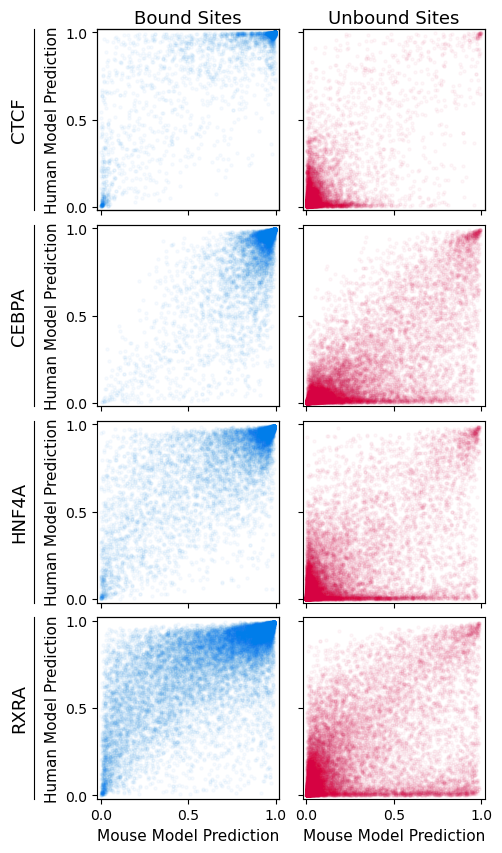

In [11]:
generate_bound_unbound_scatters(preds_and_labels_dfs,
                                train_species = ["mm10", "hg38"],
                                save_files = SAVE_FILES)

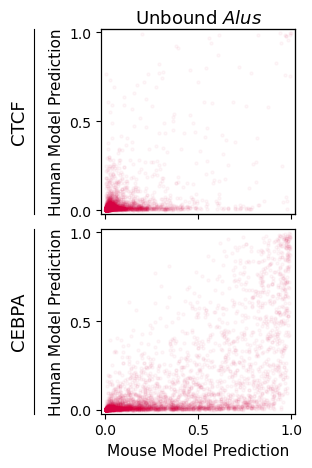

In [12]:
generate_unbound_alu_scatters(preds_and_labels_dfs,
                              train_species = ["mm10", "hg38"],
                              tf_split_half = 1,
                              save_files = SAVE_FILES)

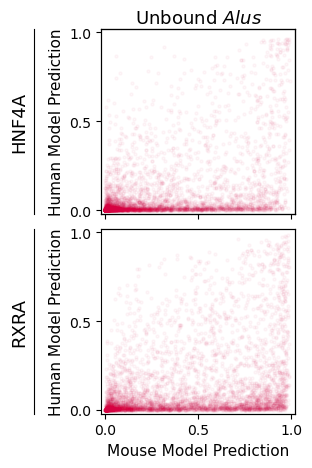

In [13]:
generate_unbound_alu_scatters(preds_and_labels_dfs,
                              train_species = ["mm10", "hg38"],
                              tf_split_half = 2,
                              save_files = SAVE_FILES)

## Domain-Adaptive Mouse vs. Human

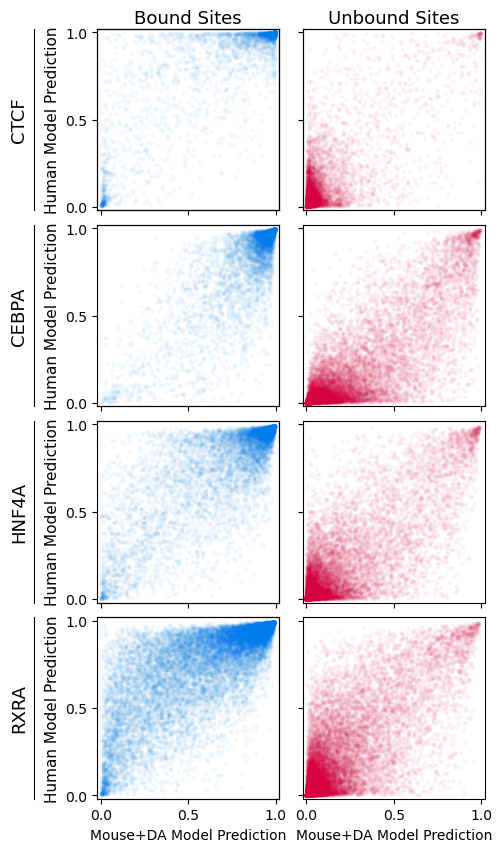

In [14]:
generate_bound_unbound_scatters(preds_and_labels_dfs,
                                train_species = ["DA", "hg38"],
                                save_files = SAVE_FILES)

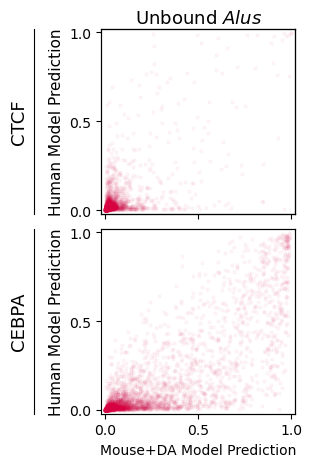

In [15]:
generate_unbound_alu_scatters(preds_and_labels_dfs,
                              train_species = ["DA", "hg38"],
                              tf_split_half = 1,
                              save_files = SAVE_FILES)

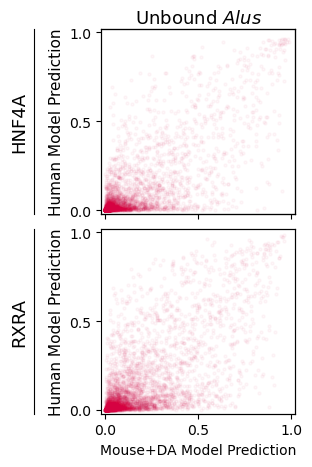

In [16]:
generate_unbound_alu_scatters(preds_and_labels_dfs,
                              train_species = ["DA", "hg38"],
                              tf_split_half = 2,
                              save_files = SAVE_FILES)

## No-SINEs Human vs. Human

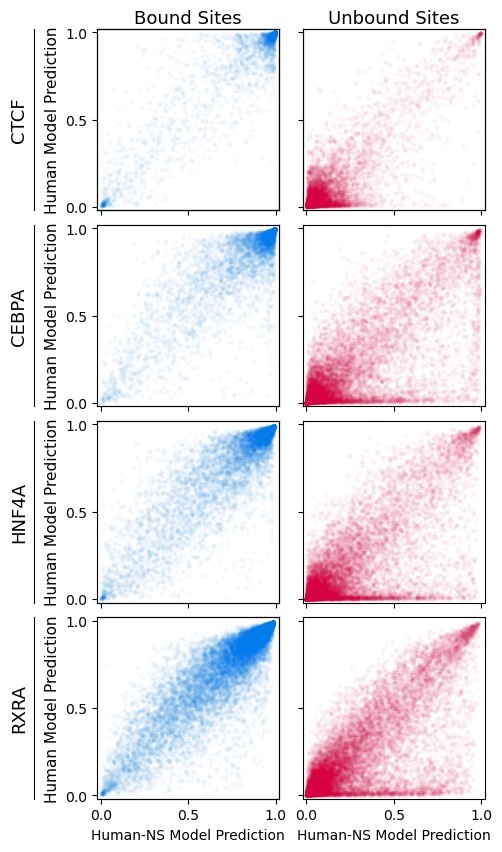

In [17]:
generate_bound_unbound_scatters(preds_and_labels_dfs,
                                train_species = ["NS", "hg38"],
                                save_files = SAVE_FILES)

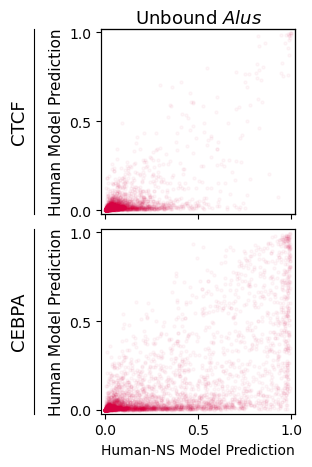

In [18]:
generate_unbound_alu_scatters(preds_and_labels_dfs,
                              train_species = ["NS", "hg38"],
                              tf_split_half = 1,
                              save_files = SAVE_FILES)

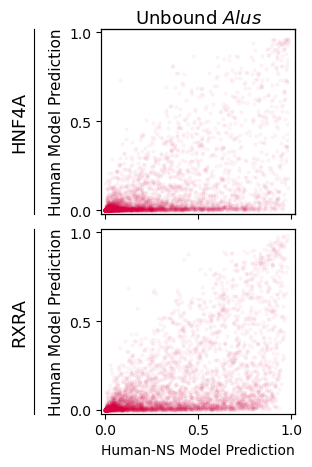

In [19]:
generate_unbound_alu_scatters(preds_and_labels_dfs,
                              train_species = ["NS", "hg38"],
                              tf_split_half = 2,
                              save_files = SAVE_FILES)

## Mouse vs. No-SINEs Human

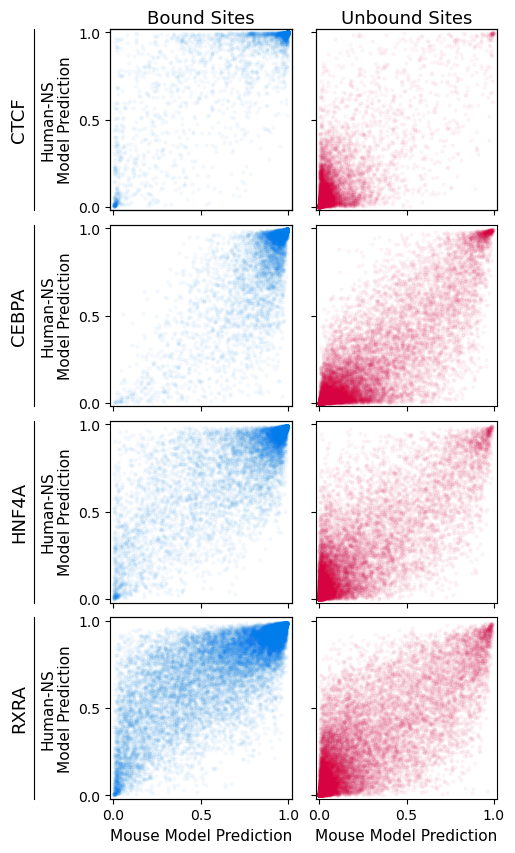

In [20]:
generate_bound_unbound_scatters(preds_and_labels_dfs,
                                train_species = ["mm10", "NS"],
                                save_files = SAVE_FILES)